In [1]:
import typing

import polyflexmd.data_analysis.plot.msd as plot_msd
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.transform.msd as msd_transform
import polyflexmd.data_analysis.plot.utils as plot_utils
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": plot_utils.get_figure_size(width=1, n_rows=1)
}

plt.rcParams.update(params)


In [2]:
PATH_REL_ETE = "data/processed/ete.csv"

In [3]:
def aggregate_time_mean_ete(df_ete: pd.DataFrame, time_bucket_size: int, var_index: list[str]) -> pd.DataFrame:
    df_ete_agg =  df_ete.groupby(var_index+["molecule-ID", df_ete.index.get_level_values("t") // time_bucket_size], as_index=True).agg(np.mean)
    df_ete_agg.reset_index(level="t", drop=False, inplace=True)
    df_ete_agg["t"] = df_ete_agg["t"]*time_bucket_size
    df_ete_agg.set_index("t", append=True, inplace=True)
    return df_ete_agg


def get_dataset_ete_equi(
        conf: config.ExperimentConfig,
        experiment_path: pathlib.Path,
        var_index: list[str]
) -> pd.DataFrame:
    df = pd.read_csv(experiment_path / PATH_REL_ETE, index_col=var_index + ["molecule-ID", "t"])
    return df.loc[df.index.get_level_values("t") >= conf.simulation_config.variables["n_relax_steps"]]

## EEA1+Rab5

In [4]:
PATH_EXPERIMENT_CONNECTED = pathlib.Path("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/538accb2")
PATH_EXPERIMENT_CONNECTED

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/538accb2')

In [5]:
CONF_CONNECTED = config.read_experiment_config(next(PATH_EXPERIMENT_CONNECTED.glob("*.toml")))
CONF_CONNECTED

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/beegfs/ws/0/s4610340-polyflexmd/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-free_chain-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 35000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 38000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(acco

### Get data

#### ETE

In [6]:
df_ete_conn = aggregate_time_mean_ete(get_dataset_ete_equi(CONF_CONNECTED, PATH_EXPERIMENT_CONNECTED, var_index=["kappa", "d_end"]), time_bucket_size=1, var_index=["kappa", "d_end"])
df_ete_conn

R_x        R_y        R_z          R
kappa d_end molecule-ID t                                                   
190.2 15.0  1           35000000  21.671394 -50.723101   6.615898  55.554049
                        35000100  21.902100 -50.612600   6.622299  55.544506
                        35000200  21.870399 -50.829500   6.785698  55.749423
                        35000300  21.662895 -50.771700   6.804001  55.617812
                        35000400  21.737801 -50.683300   7.024597  55.593829
...                                     ...        ...        ...        ...
            500         74960000  38.953680 -37.685703  24.105705  59.318517
                        74970000  37.306850 -37.336601  26.791100  59.191096
                        74980000  36.658829 -34.829304  29.803398  58.695764
                        74990000  36.636661 -39.436001  24.760899  59.249854
                        75000000  36.094070 -39.143597  24.776100  58.726980

[11900500 rows x 4 columns]

<Axes: xlabel='t', ylabel='R'>

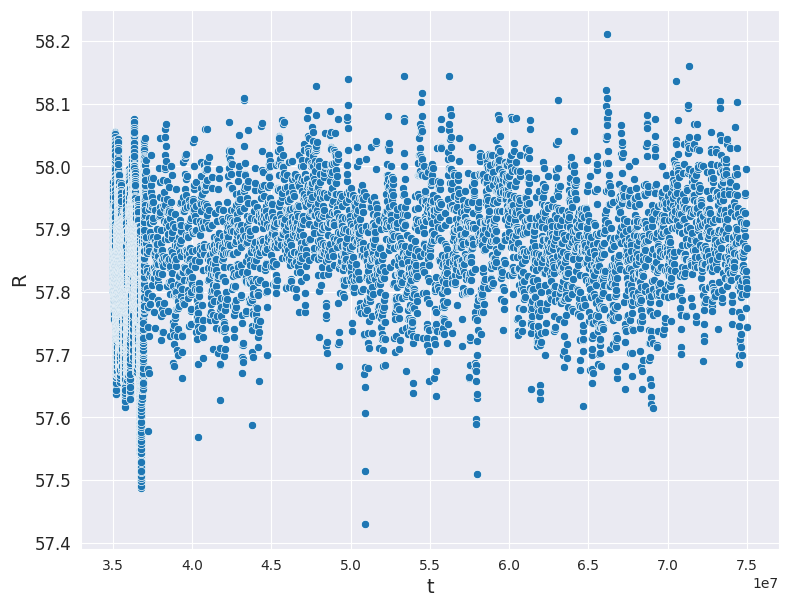

In [7]:
sns.scatterplot(
    df_ete_conn.groupby(["kappa", "d_end", "t"])["R"].mean().reset_index(),
    x="t",
    y="R",
)

#### Main axis

In [8]:
df_main_ax_conn = pd.read_csv(
    PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "main_axis.csv"
).groupby("molecule-ID", as_index=True).nth(1)
df_main_ax_conn

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,-0.336178,0.186169,0.890632,0,0,0
3,2,1,-0.272215,-0.119898,0.923268,0,0,0
5,3,1,-0.517323,-0.532615,-0.624178,0,0,0
7,4,1,0.302546,-0.396453,0.831980,0,0,0
9,5,1,-0.592061,0.192979,0.743722,0,0,0
...,...,...,...,...,...,...,...,...
991,496,1,0.301950,-0.674609,-0.628195,0,0,0
993,497,1,-0.010688,0.215110,-0.945787,0,0,0
995,498,1,-0.072238,0.104175,0.961680,0,0,0
997,499,1,-0.396090,-0.883587,0.057330,0,0,0


#### Kuhn length $l_K$

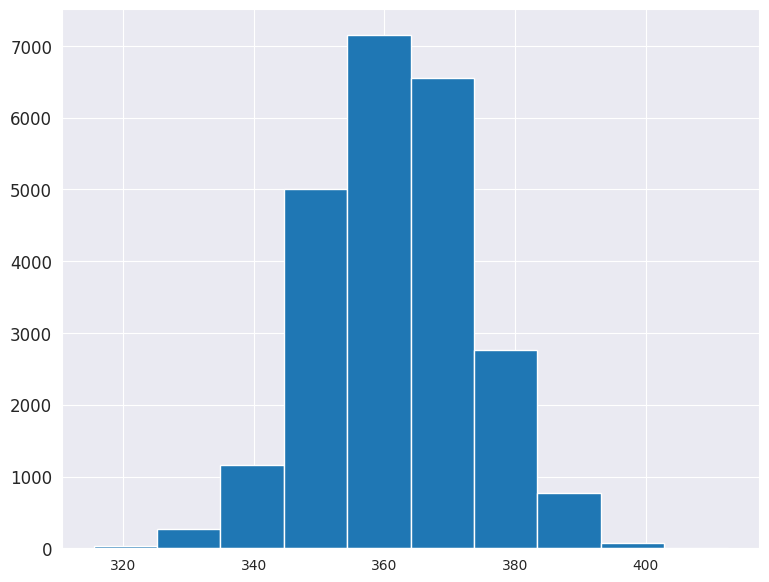

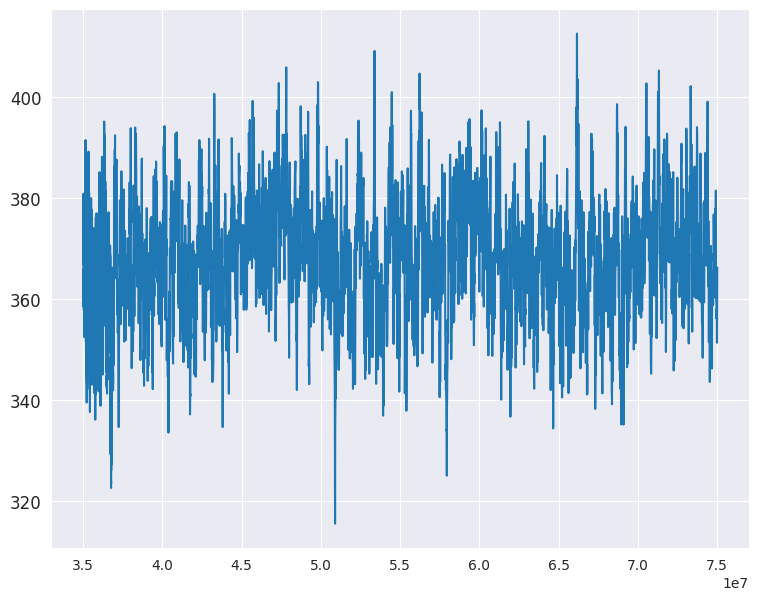

l_K        361.774935
std_l_K     11.823078
d_l_K       35.469233
Name: value, dtype: float64

In [9]:
def get_l_K_estimate(path_experiment: pathlib.Path):
    df_l_K_estimate: pd.Series = pd.read_csv(path_experiment / "data" / "processed" / "l_K-estimate.csv")
    plt.hist(df_l_K_estimate["l_K"]),
    plt.show()
    plt.plot(df_l_K_estimate["t"], df_l_K_estimate["l_K"])
    plt.show()
    l_K = df_l_K_estimate["l_K"].mean()
    std_l_K = df_l_K_estimate["l_K"].std()
    return pd.Series({
        "l_K": l_K,
        "std_l_K": std_l_K,
        "d_l_K": 3*std_l_K
    }, name="value")

l_K_estimate_conn = get_l_K_estimate(PATH_EXPERIMENT_CONNECTED)
l_K_estimate_conn

#### Bond length $l_b$

In [10]:
l_b = CONF_CONNECTED.initial_system_config.system_config.bond_length
l_b

0.97

#### Contour length L

In [11]:
L_contour = l_b*(CONF_CONNECTED.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

#### End monomer mass

In [12]:
m_end_conn = CONF_CONNECTED.simulation_config.variables["m_end"]
m_end_conn

1.5

#### Friction coefficient of end monomer $\zeta_e$

In [13]:
zeta_end_conn = CONF_CONNECTED.simulation_config.variables["d_end_start"] / m_end_conn
zeta_end_conn

10.0

#### MSD

In [14]:
def with_transformed_time_msd_df(df_msd: pd.DataFrame):
    df_msd["t/LJ"] = df_msd.index.get_level_values("t").map(lambda t: t*0.0025)
    df_msd["t/LJ"] = df_msd["t/LJ"] - df_msd["t/LJ"].min()

In [15]:
df_msd_conn = msd_transform.calculate_msd_df(df_ete_conn, ["kappa", "d_end"])
with_transformed_time_msd_df(df_msd_conn)
df_msd_conn

,dR^2,delta dR^2,kappa,d_end,t/LJ
t,,,,,
35000000,0.000000,0.000000,190.2,15.0,0.00
35000100,0.144996,0.016518,190.2,15.0,0.25
35000200,0.388052,0.044778,190.2,15.0,0.50
35000300,0.648300,0.077528,190.2,15.0,0.75
35000400,0.952308,0.111950,190.2,15.0,1.00
...,...,...,...,...,...
74960000,6454.089693,505.846411,190.2,15.0,99900.00
74970000,6444.334230,501.982749,190.2,15.0,99925.00
74980000,6464.865658,501.440027,190.2,15.0,99950.00


#### MSD by dimension in main-axis coordinate system

In [16]:
df_ete_conn_main_ax_frame = transform.change_basis_df_ete(df_ete_conn, df_main_ax_conn)
df_ete_conn_main_ax_frame

R_x        R_y        R_z          R
kappa d_end molecule-ID t                                                   
190.2 15.0  1           35000000  18.975757  51.003666 -11.171349  55.554049
                        35000100  19.202171  50.896814 -11.224220  55.544506
                        35000200  19.212487  51.142557 -11.104834  55.749423
                        35000300  19.028151  51.089725 -11.005019  55.617812
                        35000400  19.179518  51.048331 -10.811466  55.593829
...                                     ...        ...        ...        ...
            500         74960000  19.739684 -28.593892  48.077236  59.318517
                        74970000  18.562661 -31.215249  46.739938  59.191096
                        74980000  19.245918 -33.893294  43.886580  58.695764
                        74990000  16.929589 -29.461124  48.538401  59.249854
                        75000000  16.571908 -29.439940  48.036653  58.726980

[11900500 rows x 4 columns]

In [17]:
df_msd_conn_main_ax_frame = msd_transform.calculate_msd_by_dimension_df(df_ete_conn_main_ax_frame, ["kappa", "d_end"])
with_transformed_time_msd_df(df_msd_conn_main_ax_frame)
df_msd_conn_main_ax_frame

,dR_x^2,dR_y^2,dR_z^2,delta dR_x^2,delta dR_y^2,delta dR_z^2,dR^2,kappa,d_end,t/LJ
t,,,,,,,,,,
35000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,190.2,15.0,0.00
35000100,0.053006,0.046222,0.045767,0.009746,0.008836,0.009902,0.144996,190.2,15.0,0.25
35000200,0.145447,0.116759,0.125845,0.028128,0.022714,0.025511,0.388052,190.2,15.0,0.50
35000300,0.236026,0.202007,0.210267,0.048178,0.037593,0.041771,0.648300,190.2,15.0,0.75
35000400,0.349741,0.302845,0.299722,0.068931,0.058946,0.059333,0.952308,190.2,15.0,1.00
...,...,...,...,...,...,...,...,...,...,...
74960000,2004.798936,2217.683148,2231.607609,327.437342,335.224186,351.335293,6454.089693,190.2,15.0,99900.00
74970000,2000.434090,2224.683298,2219.216842,323.068076,334.710717,347.932269,6444.334230,190.2,15.0,99925.00
74980000,2001.248535,2236.585759,2227.031364,323.368877,336.025830,349.139965,6464.865658,190.2,15.0,99950.00


### Explore

#### Plot MSD

<Axes: title={'center': 'MSD for $l_K/L=5.92$, $\\zeta_e=10.0$, $\\zeta=1.0$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

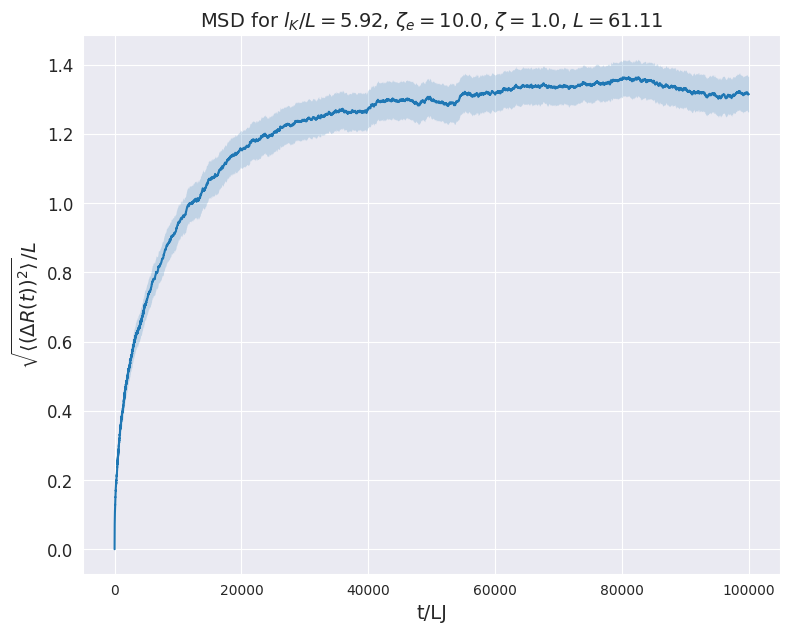

In [18]:
plot_msd.plot_MSD(df_msd_conn, log_scale=False, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

<Axes: title={'center': 'MSD on log-log scale for $l_K/L=5.92$, $\\zeta_e=10.0$, $\\zeta=1.0$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

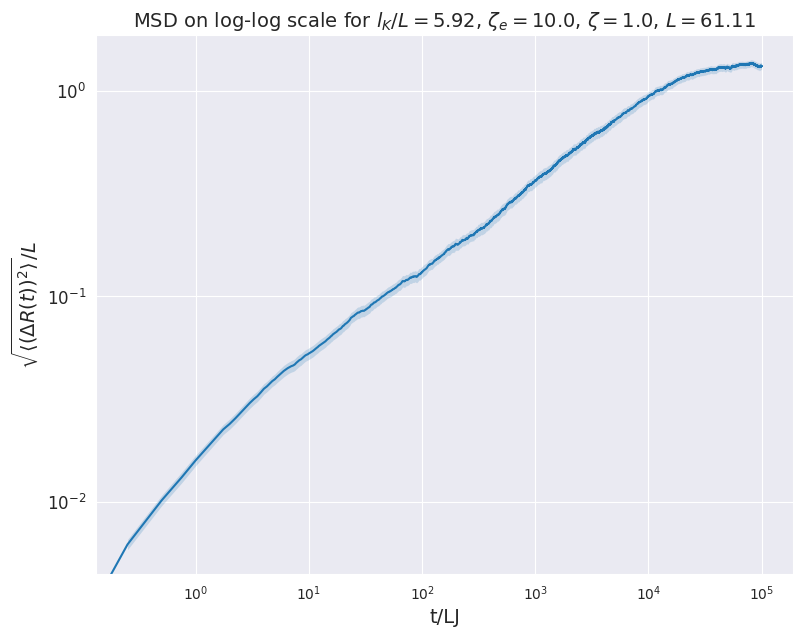

In [19]:
plot_msd.plot_MSD(df_msd_conn, log_scale=True, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

#### Plot MSD dimensions

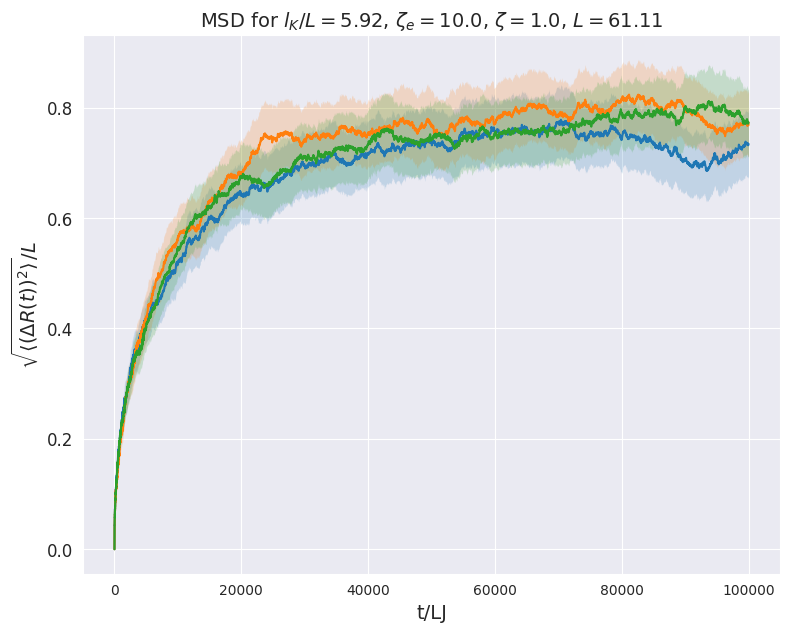

In [42]:
dims = ["x", "y", "z"]
for dim, color in zip(dims, sns.color_palette()):
    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=False,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=zeta_end_conn,
        ci_alpha=.2,
        color=color
    )


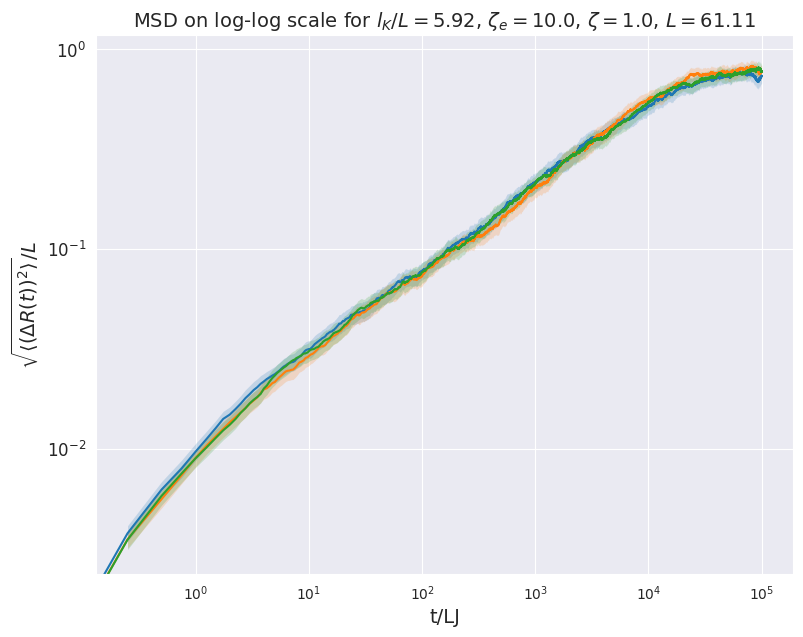

In [21]:
dims = ["x", "y", "z"]
for dim, color in zip(dims, sns.color_palette()):
    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=True,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=zeta_end_conn,
        ci_alpha=.2,
        color=color
    )

## Bare EEA1

In [22]:
PATH_EXPERIMENT_BARE = pathlib.Path("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/538accb2")
PATH_EXPERIMENT_BARE

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/538accb2')

In [23]:
CONF_BARE = config.read_experiment_config(next(PATH_EXPERIMENT_BARE.glob("*.toml")))
CONF_BARE

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/beegfs/ws/0/s4610340-polyflexmd/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-free_chain-vary-l_K.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'n_relax_steps': 35000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 38000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntas

### Get data

#### ETE

In [24]:
df_ete_bare = aggregate_time_mean_ete(
    get_dataset_ete_equi(CONF_BARE, PATH_EXPERIMENT_BARE, var_index=["kappa"]),
    time_bucket_size=1,
    var_index=["kappa"]
)
df_ete_bare

R_x        R_y        R_z          R
kappa molecule-ID t                                                  
190.2 1           35000000  2.775501  57.122600 -16.710300  59.581280
                  35000100  2.617001  57.189200 -16.753200  59.650005
                  35000200  2.547901  57.028503 -16.951603  59.549130
                  35000300  2.854899  56.912500 -16.972000  59.457813
                  35000400  3.001299  56.903100 -16.731503  59.387825
...                              ...        ...        ...        ...
      500         74960000 -0.897900  45.220300 -38.607080  59.465855
                  74970000  5.057800  45.557198 -39.148910  60.279987
                  74980000  2.460499  43.965900 -39.874240  59.405468
                  74990000  3.825001  43.458900 -40.606720  59.600440
                  75000000  3.802101  41.669600 -42.062428  59.330090

[11900500 rows x 4 columns]

<Axes: xlabel='t', ylabel='R'>

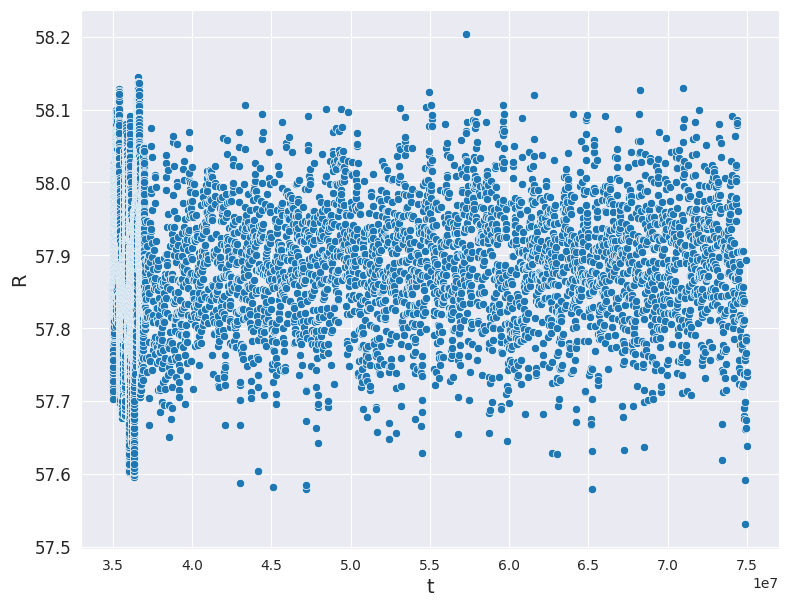

In [25]:
sns.scatterplot(
    df_ete_bare.groupby(["kappa", "t"])["R"].mean().reset_index(),
    x="t",
    y="R",
)

#### Other

In [26]:
df_main_ax_bare = pd.read_csv(
    PATH_EXPERIMENT_BARE / "data" / "processed" / "main_axis.csv"
).groupby("molecule-ID", as_index=True).nth(1)
df_main_ax_bare

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,-0.336178,0.186169,0.890632,0,0,0
3,2,1,-0.272215,-0.119898,0.923268,0,0,0
5,3,1,-0.517323,-0.532615,-0.624178,0,0,0
7,4,1,0.302546,-0.396453,0.831980,0,0,0
9,5,1,-0.592061,0.192979,0.743722,0,0,0
...,...,...,...,...,...,...,...,...
991,496,1,0.301950,-0.674609,-0.628195,0,0,0
993,497,1,-0.010688,0.215110,-0.945787,0,0,0
995,498,1,-0.072238,0.104175,0.961680,0,0,0
997,499,1,-0.396090,-0.883587,0.057330,0,0,0


In [27]:
l_b = CONF_BARE.initial_system_config.system_config.bond_length
l_b

0.97

In [28]:
kappa = CONF_BARE.simulation_config.variables["kappa_start"]
kappa

190.2

In [29]:
l_K_bare = kremer_grest.bare_kuhn_length(kappa, l_b=l_b)
l_K_bare

368.018

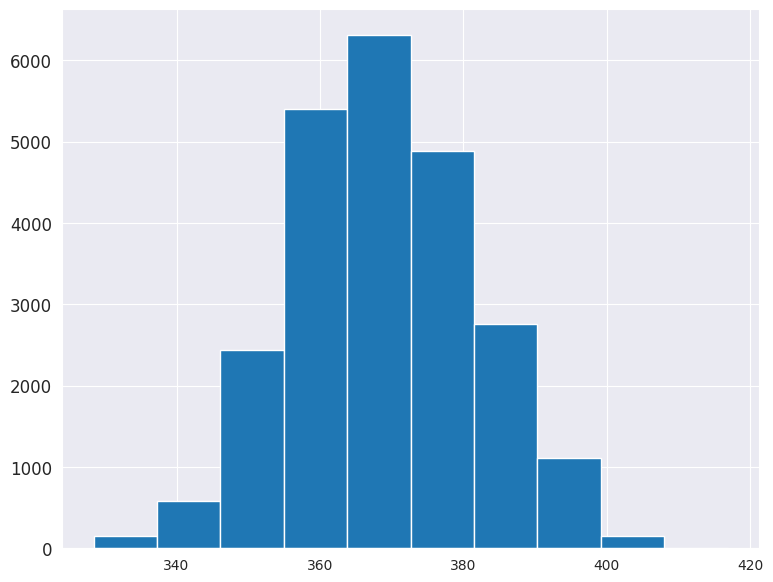

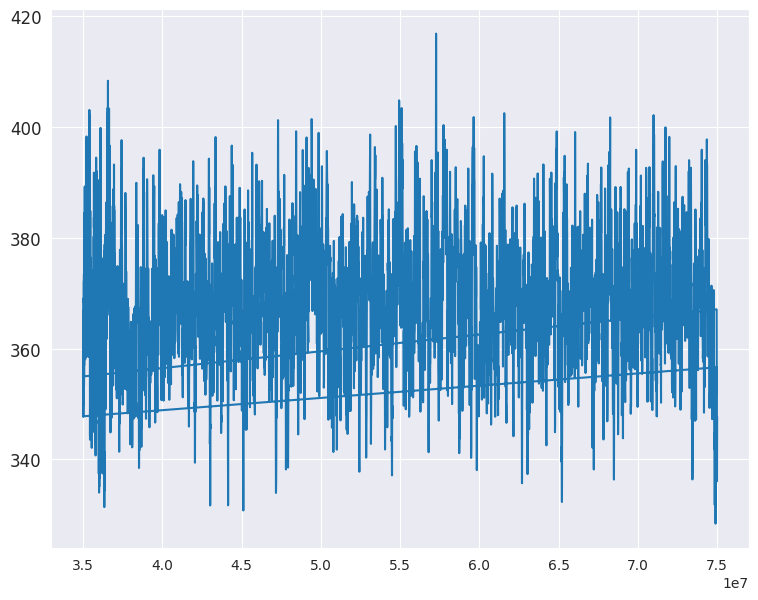

l_K        368.854196
std_l_K     12.720599
d_l_K       38.161796
Name: value, dtype: float64

In [30]:
l_K_estimate_bare = get_l_K_estimate(PATH_EXPERIMENT_BARE)
l_K_estimate_bare

#### MSD

In [31]:
df_msd_bare = msd_transform.calculate_msd_df(df_ete_bare, ["kappa"])
with_transformed_time_msd_df(df_msd_bare)
df_msd_bare

,dR^2,delta dR^2,kappa,t/LJ
t,,,,
35000000,0.000000,0.000000,190.2,0.00
35000100,0.199886,0.022916,190.2,0.25
35000200,0.584565,0.067176,190.2,0.50
35000300,1.039027,0.127447,190.2,0.75
35000400,1.496474,0.185037,190.2,1.00
...,...,...,...,...
74960000,6625.324243,524.937981,190.2,99900.00
74970000,6639.858041,524.810201,190.2,99925.00
74980000,6629.488127,526.545238,190.2,99950.00


#### MSD by dimension in main-axis c-system

In [32]:
df_ete_bare_main_ax_frame = transform.change_basis_df_ete(df_ete_bare, df_main_ax_bare)
df_ete_bare_main_ax_frame

R_x        R_y        R_z          R
kappa molecule-ID t                                                   
190.2 1           35000000   0.985318 -59.333177  -5.341555  59.581280
                  35000100   0.826810 -59.407146  -5.313230  59.650005
                  35000200   0.683291 -59.290443  -5.502293  59.549130
                  35000300   0.956115 -59.181068  -5.649683  59.457813
                  35000400   1.174363 -59.122659  -5.481407  59.387825
...                               ...        ...        ...        ...
      500         74960000  16.907593  43.917837 -36.353064  59.465855
                  74970000  22.368226  44.497270 -33.960745  60.279987
                  74980000  19.300753  45.019623 -33.611366  59.405468
                  74990000  20.262319  45.683561 -32.475576  59.600440
                  75000000  19.377372  46.906092 -30.731016  59.330090

[11900500 rows x 4 columns]

In [33]:
df_msd_bare_main_ax_frame = msd_transform.calculate_msd_by_dimension_df(df_ete_bare_main_ax_frame, ["kappa"])
with_transformed_time_msd_df(df_msd_bare_main_ax_frame)
df_msd_bare_main_ax_frame

,dR_x^2,dR_y^2,dR_z^2,delta dR_x^2,delta dR_y^2,delta dR_z^2,dR^2,kappa,t/LJ
t,,,,,,,,,
35000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,190.2,0.00
35000100,0.067999,0.061314,0.070573,0.012705,0.012214,0.013679,0.199886,190.2,0.25
35000200,0.191802,0.193890,0.198873,0.035485,0.039190,0.041031,0.584565,190.2,0.50
35000300,0.348797,0.336645,0.353585,0.070676,0.065711,0.071786,1.039027,190.2,0.75
35000400,0.504056,0.492880,0.499538,0.102953,0.099262,0.099972,1.496474,190.2,1.00
...,...,...,...,...,...,...,...,...,...
74960000,2057.121551,2109.985763,2458.216928,329.081663,354.380651,386.266447,6625.324243,190.2,99900.00
74970000,2055.435307,2110.846979,2473.575755,326.878382,352.095324,388.780454,6639.858041,190.2,99925.00
74980000,2074.857110,2111.168963,2443.462053,331.576563,349.551403,384.928984,6629.488127,190.2,99950.00


### Explore

#### Plot MSD

<Axes: title={'center': 'MSD for $l_K/L=6.02$, $\\zeta_e = \\zeta= 1.00$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

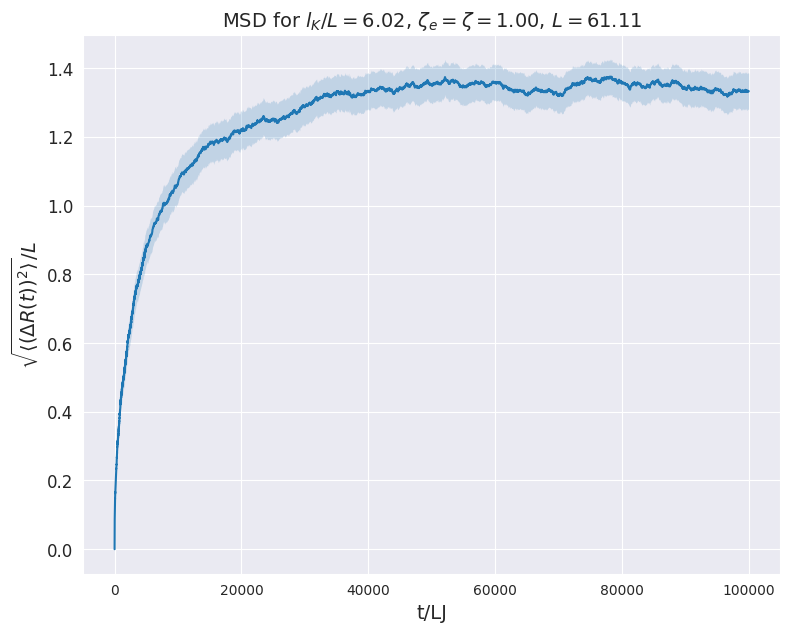

In [34]:
plot_msd.plot_MSD(df_msd_bare, log_scale=False, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

<Axes: title={'center': 'MSD on log-log scale for $l_K/L=6.02$, $\\zeta_e = \\zeta= 1.00$, $L=61.11$'}, xlabel='t/LJ', ylabel='$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$'>

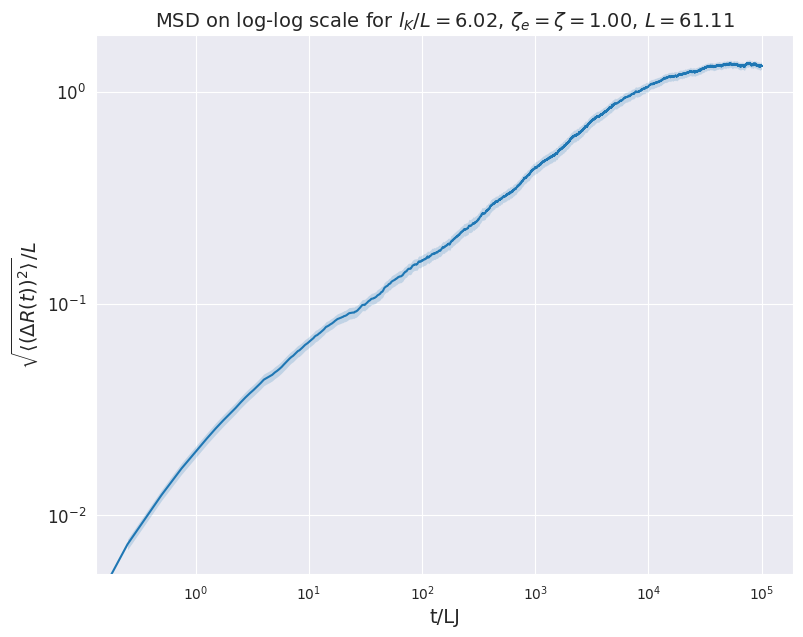

In [35]:
plot_msd.plot_MSD(df_msd_bare, log_scale=True, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

#### Plot MSD dimensions

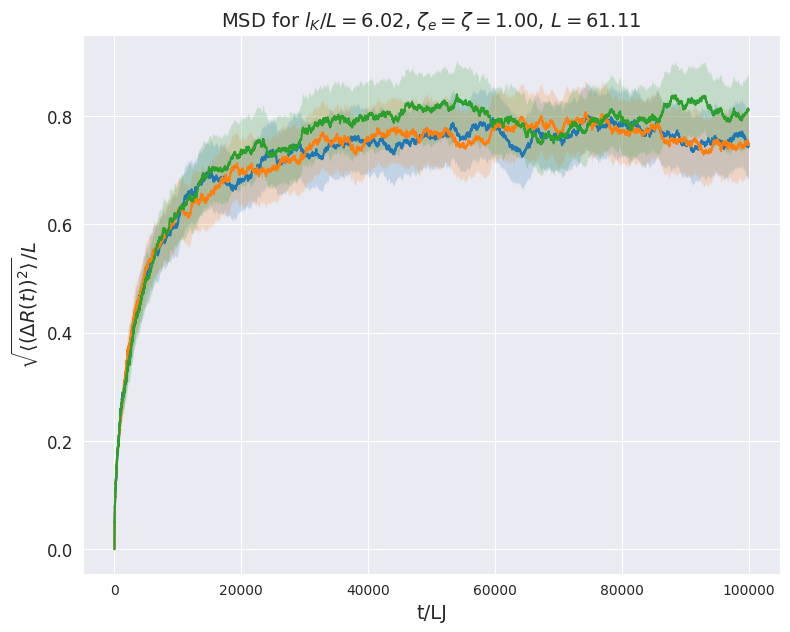

In [36]:
for color, dim in zip(sns.color_palette(), dims):
    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        log_scale=False,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=1.0,
        color=color
    )


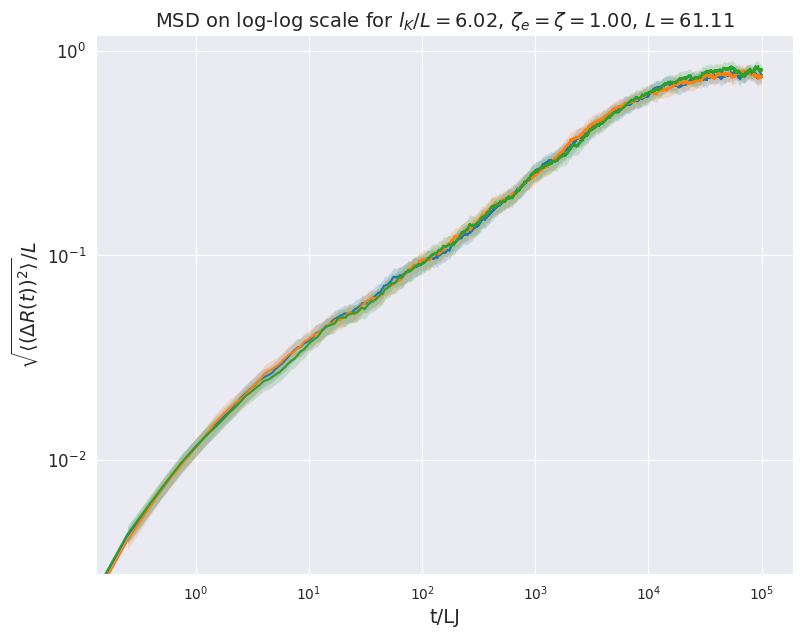

In [37]:
for color, dim in zip(sns.color_palette(), dims):
    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        log_scale=True,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=1.0,
        color=color,
    )

## Compare: EEA1+Rab5 vs EEA1

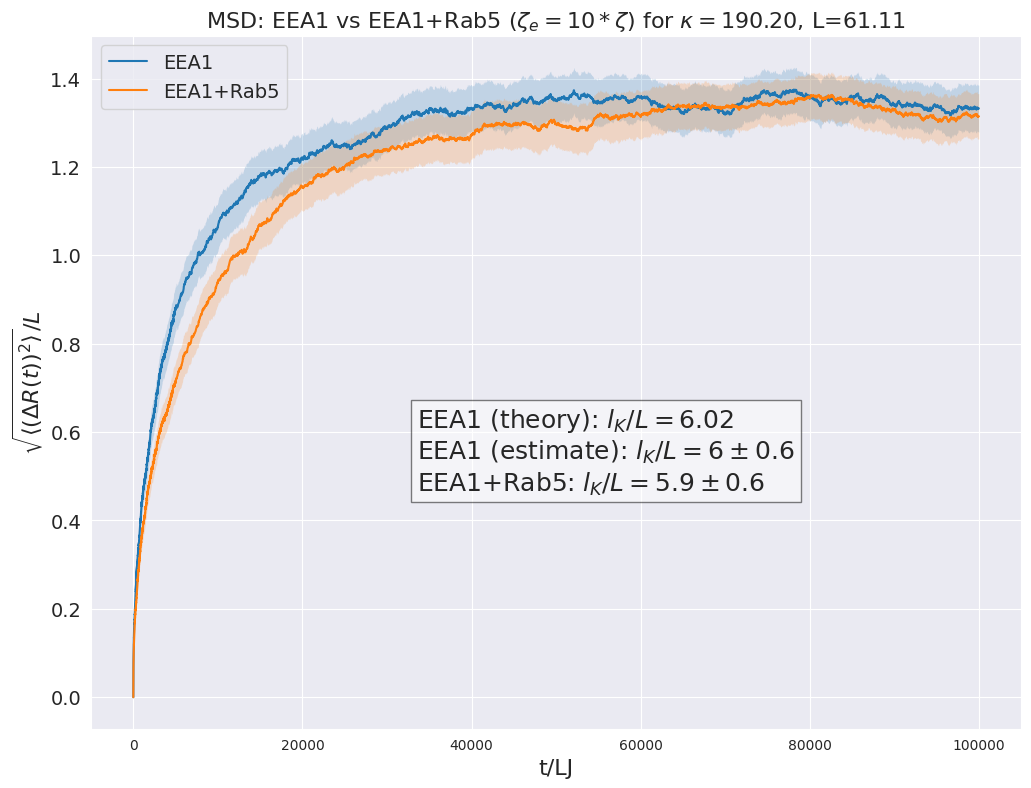

In [45]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots()

plot_msd.plot_MSD(
    df_msd_bare,
    log_scale=False,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
    color=sns.color_palette()[0]
)

plot_msd.plot_MSD(
    df_msd_conn,
    log_scale=False,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
    color=sns.color_palette()[1]
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.35,
    y=.4,
    s=f"EEA1 (theory): $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1 (estimate): $l_K/L = {l_K_estimate_bare['l_K']/L_contour : .2g} \pm {l_K_estimate_bare['d_l_K'] / L_contour:.1g}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.2g} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.1g}$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)

ax.legend()

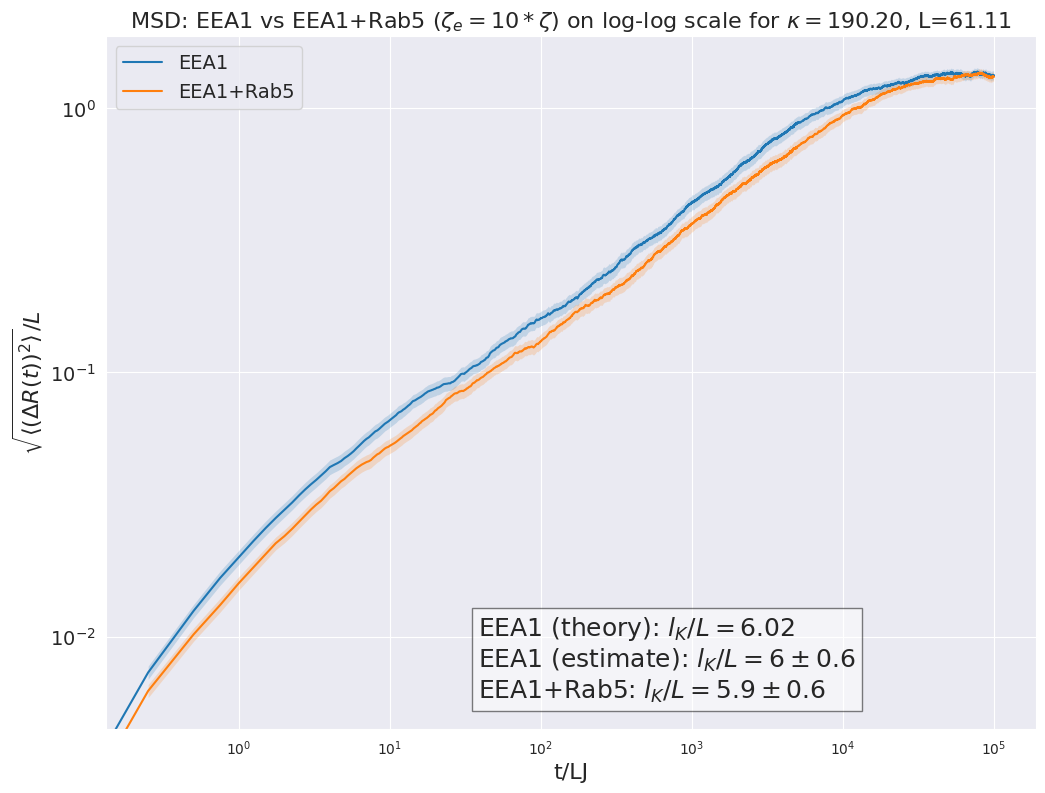

In [46]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots()

plot_msd.plot_MSD(
    df_msd_bare,
    log_scale=True,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
    color=sns.color_palette()[0]
)

plot_msd.plot_MSD(
    df_msd_conn,
    log_scale=True,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
    color=sns.color_palette()[1]
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) on log-log scale for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.4,
    y=.1,
    s=f"EEA1 (theory): $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1 (estimate): $l_K/L = {l_K_estimate_bare['l_K']/L_contour : .2g} \pm {l_K_estimate_bare['d_l_K'] / L_contour:.1g}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.2g} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.1g}$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)

ax.legend()

Text(0.5, 0.98, 'MSD in different dimensions: EEA1 vs EEA1+Rab5 ($\\zeta_e = 10*\\zeta$) on log-log scale for $\\kappa=190.20$, L=61.11')

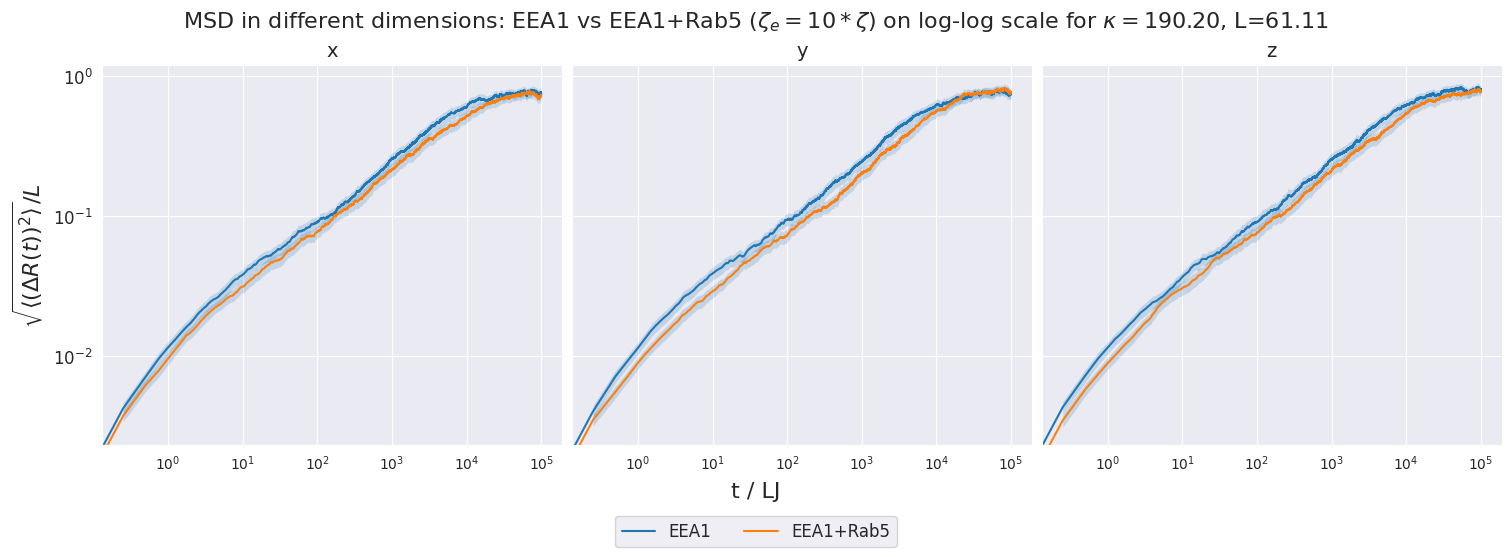

In [40]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure

fig, axs = plt.subplots(ncols=3, figsize=(15,5), sharey="all", sharex="all", layout="constrained")

for dim, ax in zip(dims, axs):

    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        col=f"dR_{dim}^2",
        log_scale=True,
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta_e=1.0,
        zeta=1.0,
        title=f"{dim}",
        ax=ax,
        label=f"EEA1",
        xlabel="",
        ylabel=""
    )

    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=True,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta_e=zeta_end_conn,
        zeta=1.0,
        title=f"{dim}",
        ax=ax,
        label=f"EEA1+Rab5",
        xlabel="",
        ylabel=""
    )

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
fig.suptitle(
    f"MSD in different dimensions: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) on log-log scale for $\kappa={kappa:.2f}$, L={L_contour:.2f}")
